In [194]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from yolov5.models.yolo import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

trained_model = trained_model.encoder
trained_model = trained_model.eval()

2023-03-14 11:12:23,733 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2023-03-14 11:12:23,735 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:98: DeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2023-03-14 11:12:23,837 - kedro.ipython - INFO - Kedro project Self-Supervised Learning
2023-03-14 11:12:23,838 - kedro.ipython - INFO - Defined global variable 'context', 'session', 'catalog' and 'pipelines'
2023-03-14 11:12:23,843 - kedro.io.data_catalog - INFO - Loading data from 'yolov5_l_description' (YAMLDataSet)...
2023-03-14 11:12:23,848 - kedro.io.data_catalog - INFO - Loading data from 'trained_model' (PytorchModelDataSet)...


2023-03-14 11:12:23.848 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [195]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "flower01" / "images"

In [196]:
# import random
# random.sample(range(160), 10)

# indices = [143, 159, 78, 12, 34, 116, 118, 0, 44, 124]

In [197]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
# image_list = [image_list[i] for i in indices]
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 458/458 [01:09<00:00,  6.64it/s]


In [198]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "flower01" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
# labels_list = [labels_list[i] for i in indices]
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.635938,0.238889,0.020833,0.037037,000001.txt
1,0,0.379427,0.065278,0.015104,0.034259,000001.txt
2,0,0.634375,0.245370,0.020833,0.037037,000002.txt
3,0,0.379948,0.068981,0.015104,0.034259,000002.txt
4,0,0.379948,0.069907,0.015104,0.034259,000003.txt
...,...,...,...,...,...,...
1987,0,0.495833,0.971759,0.030208,0.052778,000383.txt
1988,0,0.496875,0.976852,0.030208,0.046296,000384.txt
1989,0,0.497656,0.980093,0.028646,0.037963,000385.txt
1990,0,0.497135,0.986111,0.028646,0.027778,000386.txt


In [199]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [200]:
test_image_dir = dataset_path / "flower02" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().reshape((1, -1)).numpy())

100%|████████████████████████████████████████████████████| 333/333 [00:49<00:00,  6.67it/s]


In [201]:
test_labels_dir = dataset_path / "flower02" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.407813,0.032870,0.014583,0.023148,000001.txt
1,0,0.408854,0.042130,0.014583,0.023148,000002.txt
2,0,0.408854,0.042130,0.014583,0.023148,000003.txt
3,0,0.408854,0.042130,0.014583,0.023148,000004.txt
4,0,0.408854,0.042130,0.014583,0.023148,000005.txt
...,...,...,...,...,...,...
1583,0,0.441406,0.814352,0.020313,0.036111,000287.txt
1584,0,0.437240,0.838426,0.020313,0.036111,000288.txt
1585,0,0.433073,0.858796,0.020313,0.036111,000289.txt
1586,0,0.434635,0.871759,0.011979,0.028704,000290.txt


In [202]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [203]:
from sklearn.model_selection import PredefinedSplit

# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = [-1] * len(image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [204]:
from sklearn.linear_model import RidgeCV, Ridge

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg_search = RidgeCV(alphas=alphas, cv=split).fit(all_image_reps_arr, all_flower_counts)
# RidgeCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = Ridge(reg_search.alpha_).fit(np.concatenate(image_reps, axis=0), np.array(flower_counts))

2023-03-14 11:15:00,128 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.24723e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)

2023-03-14 11:15:01,079 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.24723e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)

2023-03-14 11:15:02,067 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.24723e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)

2023-03-14 11:15:03,024 - py.warnings - WAR

In [205]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.6924,      1.8198,      1.8391,      1.8559,      1.9801,      2.0676,      1.9549,      2.0169,      2.2519,      2.6322,      2.5831,      2.5665,       2.594,      2.4063,      2.1243,       2.518,       2.748,      3.0247,      2.9599,      2.7449,      2.7372,      2.7771,      2.9823,      2.8451,
             2.733,      3.2844,      3.2896,      3.2399,      3.4068,      3.4572,      3.5502,      3.4855,      3.5517,      3.1828,      3.0682,      3.0915,      3.1076,      3.4288,      3.6437,       3.366,      3.4762,      3.3918,      3.3209,      3.3816,      3.5456,       3.211,      3.1888,      3.2684,
            3.2421,      3.4476,      3.4745,      3.9538,      4.1597,      4.2592,      4.5214,      4.5979,      4.5221,      4.6152,      4.5763,      5.1657,      4.9912,      5.2897,      5.3194,      5.4894,      5.3901,      5.5784,        6.05,      5.9667,      6.2408,      5.7569,      6.2338,      5.4316,
            5.7353,      6.3581,      5.7672,      5.6639,      5.9648,      5.8422,      5.3474,      5.7125,      5.4731,      5.6215,      5.4751,       5.802,      6.0657,      5.9871,      6.1741,      5.9811,      5.9848,      5.7724,      5.6859,      5.2278,      5.4041,      5.3849,      5.3402,      4.9738,
            4.7912,      4.6143,      4.5126,      4.7156,      4.9229,      4.5995,      5.0421,      5.1552,      4.9197,      4.8761,       5.029,      4.8514,      4.4949,      4.1833,      4.1422,      3.8414,      4.4366,      4.2215,      4.5009,      4.8429,      4.9789,      4.9084,      5.2463,      5.4233,
            4.8877,      4.9131,       4.256,      3.9497,      3.4554,      3.3496,      3.6135,      3.4917,      3.4486,      3.5898,      3.8897,      4.3415,      4.7736,      4.7839,      4.5688,      4.4866,      4.3002,      4.7535,      4.4741,      4.0272,      4.1024,      3.9888,      3.5437,      3.4416,
             3.173,      3.2289,      3.2174,      3.1418,      3.3667,      3.9381,      3.7031,      4.5042,      4.6313,      4.2298,      3.9373,      4.2197,      3.7028,      3.6303,      4.0152,      3.9325,      4.1615,      4.3514,      3.8635,      4.1403,      3.8619,        3.94,      4.3934,      4.7576,
            4.3832,      4.5856,      4.9591,       4.778,      4.9169,      5.4117,      4.9228,      5.3862,      4.7266,      4.2655,      4.2419,      4.2928,      3.7235,      3.7536,      3.6274,      4.2549,      3.9464,      4.0947,      4.0708,      4.2728,      4.4639,      4.6828,       4.616,      4.6369,
            4.5059,      4.5219,      4.6149,        3.68,      4.3243,      5.1756,      4.5578,      4.9482,      4.7937,       5.232,      4.9123,      4.7019,      5.0396,      4.7606,      4.3194,      4.1927,      4.7748,      5.2443,      5.7859,      5.9924,      5.6643,      5.5967,      5.7331,      5.2394,
            5.2482,      4.9834,      5.5435,      5.0571,      5.2592,       5.811,       5.999,      5.5037,      5.2623,      5.3511,       5.296,      4.8624,      4.9241,      5.2452,      5.6729,      5.9596,      5.5135,       5.526,      5.8262,      5.7494,      5.3743,      5.2673,      4.9049,      4.8259,
            4.5701,      4.7623,      4.8795,      4.8542,      4.8398,      5.3498,      4.9224,       4.519,      4.2981,      4.4281,      4.6817,      4.6138,      4.6202,      4.7636,      4.2975,      4.2098,      4.0983,      3.5589,      3.5674,      3.3014,      3.4522,      3.2316,      3.3832,      3.1741,
            3.3512,      3.3954,      2.9876,      3.0771,      2.9341,      2.6883,      2.6697,       2.445,      2.6477,      2.0592,      2.1338,      1.8642,      2.2638,      1.5696,      1.7706,      1.6433,      1.7256,      1.6345,      1.6909,      1.7581,      1.7705,      1.6725,      1.4896,     0.97424,
           0.80646,     0.88177,     0.85935,      1.1362,     0.68893,     0.95585,     0.96339,     0.84161,     0.39746,     0.28421,     0.30498,     0.19874,     0.483

In [206]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

1.5237297542818315

2023-03-14 11:15:18,529 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-14 11:15:18,530 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



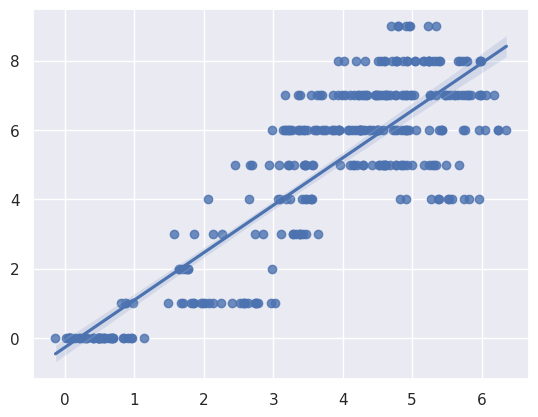

In [207]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

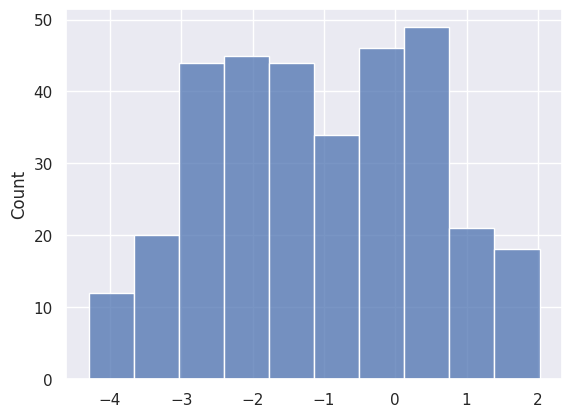

In [208]:
sns.histplot(x=errors)

In [209]:
import numpy as np

# Use the coefficient of variation of the differences between frames to provide a measure of "smoothness".
gt_diff = np.diff(test_flower_counts)
gt_smoothness = np.std(gt_diff) / np.abs(np.mean(gt_diff))
gt_smoothness

149.14087300267488

In [210]:
pred_diff = np.diff(test_preds)
pred_smoothness = np.std(pred_diff) / np.abs(np.mean(pred_diff))
pred_smoothness

124.59188

In [211]:
reps_diff = np.diff(test_image_reps_arr, axis=0)
reps_smoothness = np.std(reps_diff, axis=0) / np.abs(np.mean(reps_diff, axis=0))
np.mean(reps_smoothness)

3826.997